In [1]:
import netCDF4
from numpy import ma
import scipy.io
import pyresample as pr
import numpy as np
fill_value = int(-32767)
import os

src_dir = '/nfs1/store/satellite/AMSR2/2016/2016.01/L1/L1R/2/'
out_dir = '/nfs1/tmp/AMSR2_2016_01_L1R/'


In [2]:
def read_vars(infile):
    ds = netCDF4.Dataset(infile)
#     lon89a = ds.variables['Longitude of Observation Point for 89A'][:]
#     lat89a = ds.variables['Latitude of Observation Point for 89A'][:]
#     t89ha = ds.variables['Brightness Temperature (89.0GHz-A,H)'][:]*ds.variables['Brightness Temperature (89.0GHz-A,H)'].getncattr('SCALE FACTOR')
#     t89va = ds.variables['Brightness Temperature (89.0GHz-A,V)'][:]*ds.variables['Brightness Temperature (89.0GHz-A,V)'].getncattr('SCALE FACTOR')
#     lon89b = ds.variables['Longitude of Observation Point for 89B'][:]
#     lat89b = ds.variables['Latitude of Observation Point for 89B'][:]
#     t89hb = ds.variables['Brightness Temperature (89.0GHz-B,H)'][:]*ds.variables['Brightness Temperature (89.0GHz-B,H)'].getncattr('SCALE FACTOR')
#     t89vb = ds.variables['Brightness Temperature (89.0GHz-B,V)'][:]*ds.variables['Brightness Temperature (89.0GHz-B,V)'].getncattr('SCALE FACTOR')

    lon89a = ds.variables['Longitude of Observation Point for 89A'][:]
    lat89a = ds.variables['Latitude of Observation Point for 89A'][:]
    t89ha = ds.variables['Brightness Temperature (original,89GHz-A,H)'][:]*ds.variables['Brightness Temperature (original,89GHz-A,H)'].getncattr('SCALE FACTOR')
    t89va = ds.variables['Brightness Temperature (original,89GHz-A,V)'][:]*ds.variables['Brightness Temperature (original,89GHz-A,V)'].getncattr('SCALE FACTOR')
    lon89b = ds.variables['Longitude of Observation Point for 89B'][:]
    lat89b = ds.variables['Latitude of Observation Point for 89B'][:]
    t89hb = ds.variables['Brightness Temperature (original,89GHz-B,H)'][:]*ds.variables['Brightness Temperature (original,89GHz-B,H)'].getncattr('SCALE FACTOR')
    t89vb = ds.variables['Brightness Temperature (original,89GHz-B,V)'][:]*ds.variables['Brightness Temperature (original,89GHz-B,V)'].getncattr('SCALE FACTOR')
    
    lon89ab = np.concatenate((lon89a, lon89b), axis=0)
    del lon89a
    del lon89b
    lat89ab = np.concatenate((lat89a, lat89b), axis=0)
    del lat89a
    del lat89b
    t89hab = np.concatenate((t89ha, t89hb), axis=0)
    del t89ha
    del t89hb
    t89vab = np.concatenate((t89va, t89vb), axis=0)
    del t89va
    del t89vb
    ds.close()
    return lat89ab, lon89ab, t89hab, t89vab

def griding_data(data_array, lat, lon, g_def, radius_of_influence=15000):
    lon = pr.utils.wrap_longitudes(lon)
    if lat.ndim < 2 and lon.ndim < 2:
        x, y = np.meshgrid(lon, lat)
        swath_def = pr.geometry.GridDefinition(x, y)
    else:
        swath_def = pr.geometry.SwathDefinition(lons=lon, lats=lat)
    grided_data = pr.kd_tree.resample_nearest(
        swath_def, data_array, g_def,
        radius_of_influence=radius_of_influence,
        fill_value=int(-32767), nprocs=3
        )
    return grided_data

def get_t_swath():
    grid_ds = netCDF4.Dataset('/nfs1/tmp/LongitudeLatitudeGrid_3.125km_Arctic.nc')
    lats = grid_ds.variables['latitude'][:]
    lons = grid_ds.variables['longitude'][:]
    lons = pr.utils.wrap_longitudes(lons)
    g_def = pr.geometry.SwathDefinition(lons, lats)
    grid_ds.close()
    return g_def, lats, lons

In [3]:
def write_arr_to_mat(infile, outfile, g_def, lats, lons):
    lat89ab, lon89ab, t89hab, t89vab = read_vars(infile)
#     g_def, lats, lons = get_t_swath()
    
    gridded_t89hab = griding_data(t89hab, lat89ab, lon89ab, g_def)
    gridded_t89hab = ma.masked_where(gridded_t89hab == fill_value, gridded_t89hab)
    gridded_t89vab = griding_data(t89vab, lat89ab, lon89ab, g_def)
    gridded_t89vab = ma.masked_where(gridded_t89vab == fill_value, gridded_t89vab)
    
    scipy.io.savemat(outfile+'.mat', mdict={'lats':lats, 'lons': lons, 
                                           'gridded_t89hab': gridded_t89hab.data,
                                           'gridded_t89vab': gridded_t89vab.data})
    del gridded_t89hab
    del gridded_t89vab
    del lat89ab
    del lon89ab
    del t89hab
    del t89vab

In [4]:
def get_tmp_dir():
    if os.path.exists('/nfs1/tmp'):
        return '/nfs1/tmp'
    elif os.path.exists('/media/SOLabNFS2/tmp'):
        return '/media/SOLabNFS2/tmp'
    return '/tmp'

In [5]:
g_def, lats, lons = get_t_swath()

for root, dirs, files in os.walk(src_dir):
    print 'Start %s' % root
    base_name = os.path.basename(root)
    for filename in files:
        print 'granule: %s' % filename
        outfile = os.path.join(out_dir, filename)
        if os.path.isfile(outfile):
            continue
        if os.path.exists(outfile):
            continue
        infile = os.path.join(root, filename)
        unzipfile = os.path.join(
            get_tmp_dir(),
            os.path.basename(infile[:-3])
        )
        os.system('gzip -dc < %s > %s ' % (infile, unzipfile))
        
        write_arr_to_mat(unzipfile, outfile, g_def, lats, lons)
        os.remove(unzipfile)

Start /nfs1/store/satellite/AMSR2/2016/2016.01/L1/L1R/2/
granule: GW1AM2_201601010025_186D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010115_186A_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010254_202A_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010204_202D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010343_218D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010433_218A_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010522_001D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010612_001A_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010701_017D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010750_017A_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010840_033D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601010929_033A_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601011019_049D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601011158_065D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601011108_049A_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601011337_081D_L1SGRTBR_2210210.h5.gz
granule: GW1AM2_201601011247_06

KeyboardInterrupt: 

In [31]:
matf = scipy.io.loadmat('/nfs1/tmp/AMSR2_2016_01_L1R/GW1AM2_201601010025_186D_L1SGRTBR_2210210.h5.gz.mat')

In [33]:
matf.keys()

['lats',
 'gridded_t89hab',
 '__header__',
 '__globals__',
 'gridded_t89vab',
 'lons',
 '__version__']

In [40]:
t89hab = ma.masked_where(matf['gridded_t89hab'] == -32767., matf['gridded_t89hab'])

In [29]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


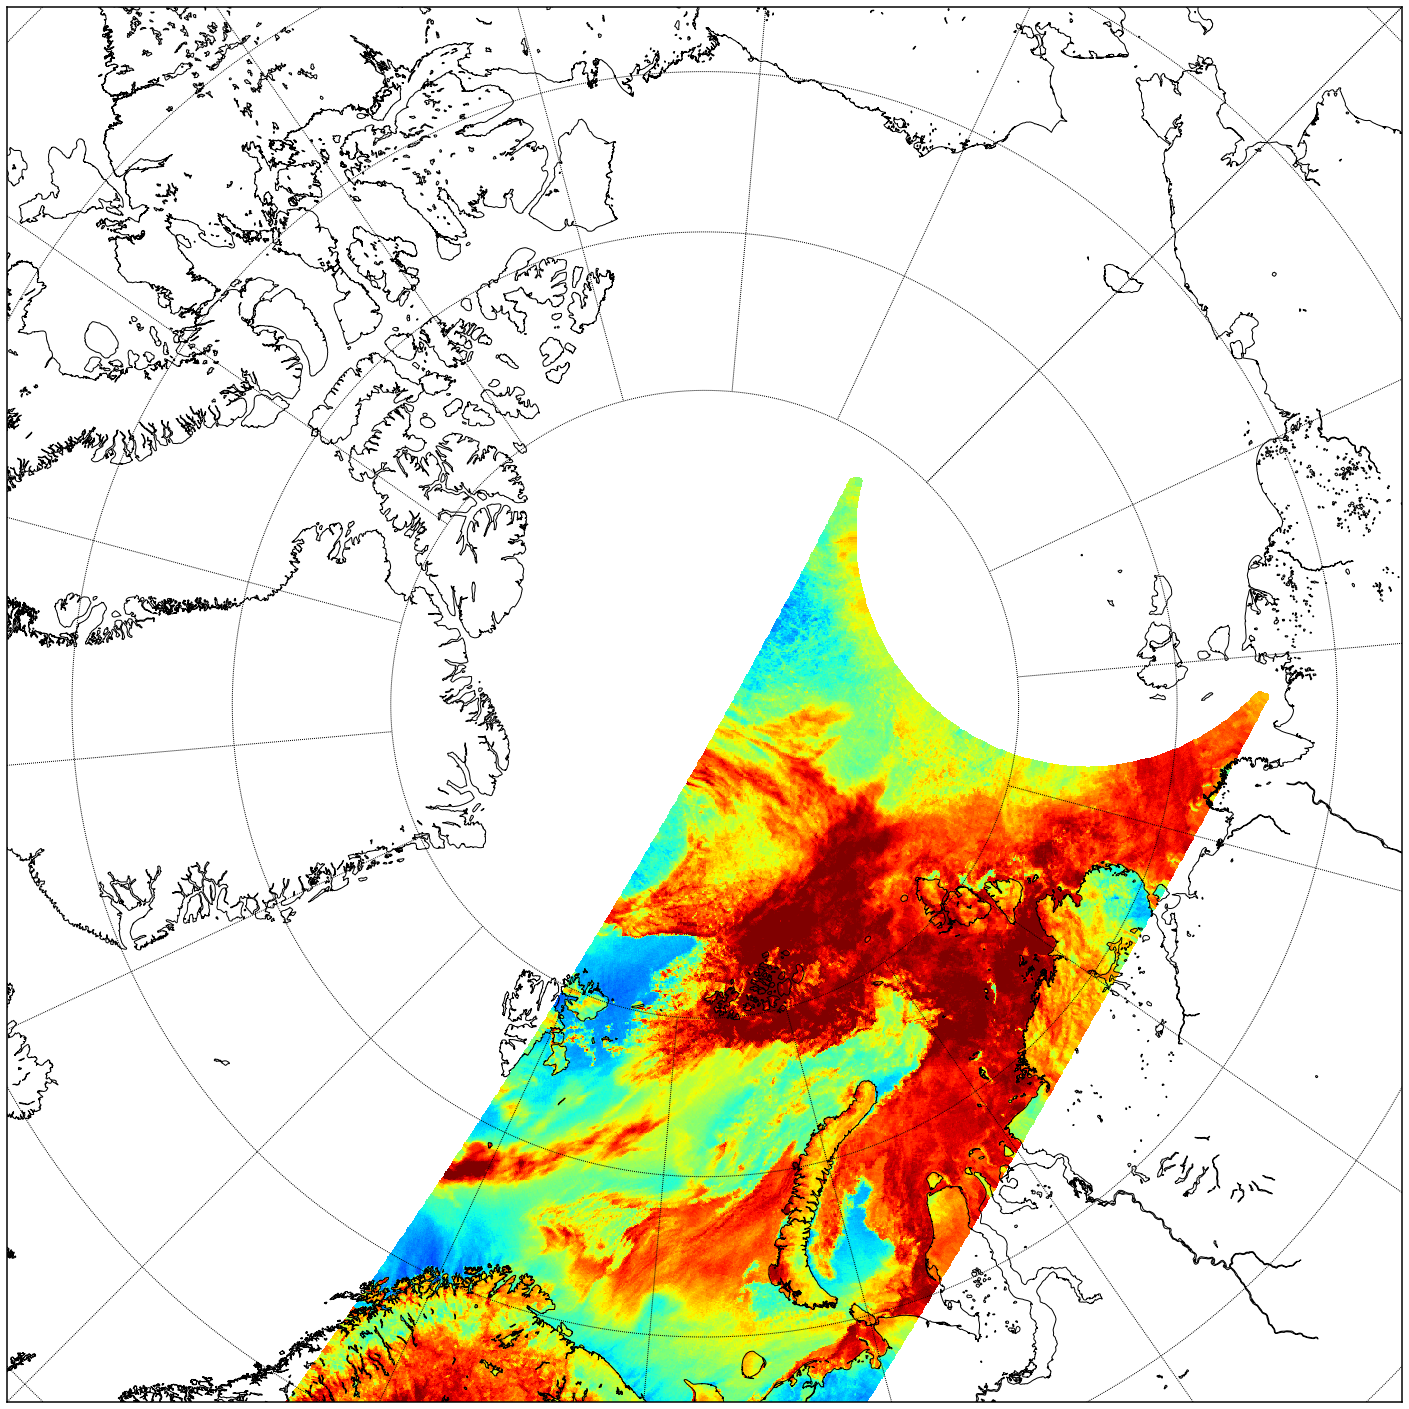

In [44]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='npstere',boundinglat=68,lon_0=45,resolution='h')
x, y = m(matf['lons'][:],matf['lats'][:])


fig = plt.figure(figsize=(25,25))
m.drawcoastlines()
# m.fillcontinents(color='brown',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,5.))
m.drawmeridians(np.arange(-180.,181.,20.))
# m.drawmapboundary(fill_color='aqua')
# m.bluemarble()
# m.contourf(x,y,gridded_t89hab, vmin=180, vmax=250)
m.pcolormesh(x,y,t89hab, vmin=150, vmax=257)